In [31]:
# imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from contextlib import redirect_stdout
from tqdm import tqdm


import os
import h5py
import json
import gc
import io

from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt

In [24]:
# Load data

# Paths & indices
h5_path = '/home/all/processed_data/image_torchtensor_1024.h5'  # Update with your path
styles = np.load('/home/all/processed_data/styles_1024.npy', allow_pickle=True)  # Your styles data


# Load one image to get the input shape
with h5py.File(h5_path, 'r') as h5file:
    one_file = h5file['images'][0:1]  # Load the first image

# Not going to load X yet. because it is too big.
# We are going to load X batch by batch when model.fit.

le = LabelEncoder()
y = le.fit_transform(styles)

# Convert the NumPy array of labels into a torch tensor
# y_tensor = torch.from_numpy(y).long()  # Ensure it's a LongTensor for classification tasks


# Assuming total number of images
num_images = len(y)  # or len(combined_df)
indices = np.arange(num_images)

print('Data load success')

# Split indices
indices_train, indices_temp, y_train, y_temp = train_test_split(indices,y, test_size=0.2, random_state=1, stratify=y)
indices_val, indices_test, y_val, y_test = train_test_split(indices_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

np.save('indices_test.npy', np.array(indices_test))

class H5Dataset(Dataset):
    def __init__(self, h5_path, indices, styles):
        self.h5_path = h5_path
        self.indices = indices
        self.styles = styles

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as h5file:
            # Use the index to access the image and label
            image = h5file['images'][self.indices[idx]]
            styles = self.styles[self.indices[idx]]
            return torch.from_numpy(image).float(), torch.tensor(styles).long()

# Load your data and labels
train_data = H5Dataset(h5_path, indices_train, y)
val_data = H5Dataset(h5_path, indices_val, y)
test_data = H5Dataset(h5_path, indices_test, y)

batch_size = 16  # Define your batch size

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print('Data loader set')

Data load success
Data loader set


In [25]:
model = torch.load('Conv2D_handmade_model.pth')

# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [26]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in test_loader:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')

# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Accuracy of the model on the test images: 85.70212765957447%
Precision: 0.8543565911718793
Recall: 0.8570212765957447
F1 Score: 0.8505057048785344
Confusion Matrix:
 [[ 79   3   0   0  46   0   0]
 [  4  48   0   0  34   0   1]
 [  4   2  51   0  16   0   1]
 [  0   1   0  12   3   0   0]
 [ 24   8   3   0 782   0   2]
 [  0   0   0   0   3   3   0]
 [  0   0   1   0  12   0  32]]


In [28]:
# Assuming le is your LabelEncoder object and y_pred_labels are your predicted labels
label_names = le.inverse_transform([0,1,2,3,4,5,6])

# Now label_names will have the original string names of the labels
print(label_names)

['Classic' 'Contemporary' 'Country' 'Minimalism' 'Modern' 'Unique' 'Urban']


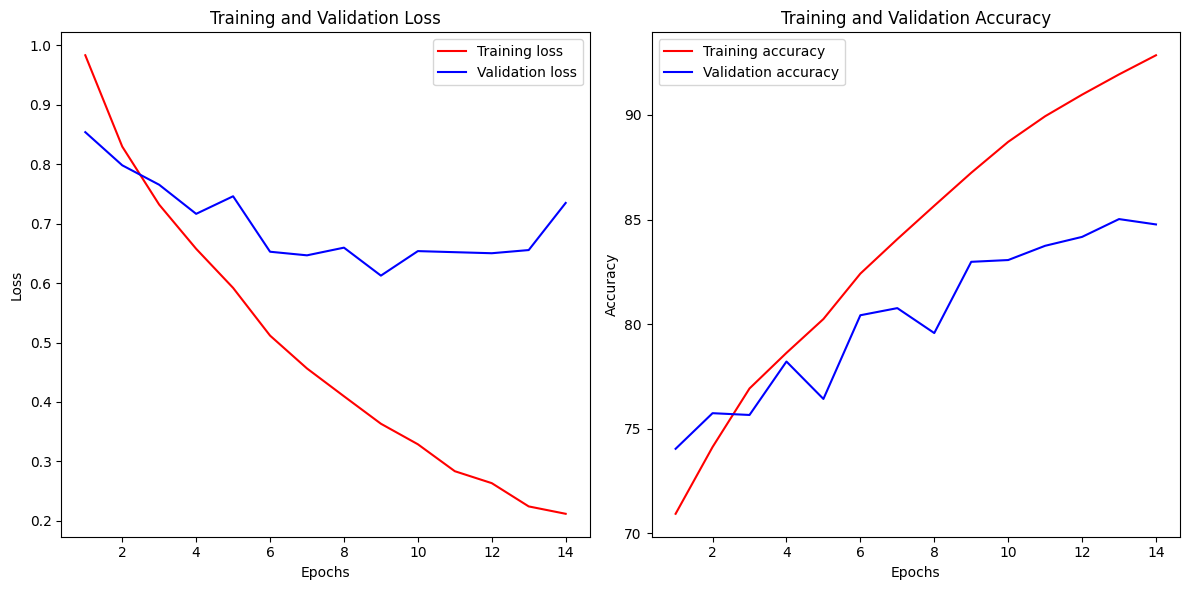

In [32]:
with open('history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()